<h1>"Louis, I think this is the beginning of a beautiful friendship."</h1>

In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
from os.path import isfile, join
from PIL import Image
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors

In [2]:
#Reading .csv file containing metadata about the segmentation
print("Reading file containing metadata about the segmentation...")
metadf = pd.read_csv('data/categories.csv', sep=',')

#Organizing subcategories into an array, and counting subcategories
subcat = []
no_subcat = 0
for row in metadf.name:
    subcat.append(row)
no_subcat = len(subcat)

#Organizing categories into an array
cat = []
for row in metadf.category:
    cat.append(row)

#Organizing category Ids into an array
catid = []
for row in metadf.catId:
    catid.append(row)
#Counting categories
no_cat = 1
act = catid[0]
categories = [] #array containing categories without duplication
categories.append(cat[0])
for i in range(len(catid)):
    if catid[i]!=act:
        categories.append(cat[i])
        no_cat+=1
        act=catid[i]

#Organizing subcategory RGB colors into an array
col = []
for row in metadf.color:
    c = row.replace(" ", "").split(',')
    rgb = []
    for i in c:
        rgb.append(int(i))
    col.append(rgb)


print('Number of segmentation subcategories:', no_subcat)
print('Number of segmentation categories:', no_cat, "\n")
print("Subcategories and their representational colors [R, G, B]: \n")
for i in range(len(subcat)):
    print("%30s \t" % subcat[i], end ="")
    print(i, "  ", col[i])

Reading file containing metadata about the segmentation...
Number of segmentation subcategories: 41
Number of segmentation categories: 8 

Subcategories and their representational colors [R, G, B]: 

                     unlabeled 	0    [0, 0, 0]
                       dynamic 	1    [111, 74, 0]
                   ego vehicle 	2    [0, 0, 0]
                        ground 	3    [81, 0, 81]
                        static 	4    [0, 0, 0]
                       parking 	5    [250, 170, 160]
                    rail track 	6    [230, 150, 140]
                          road 	7    [128, 64, 128]
                      sidewalk 	8    [244, 35, 232]
                        bridge 	9    [150, 100, 100]
                      building 	10    [70, 70, 70]
                         fence 	11    [190, 153, 153]
                        garage 	12    [180, 100, 180]
                    guard rail 	13    [180, 165, 180]
                        tunnel 	14    [150, 120, 90]
                         wall  

In [3]:
#Reading filenames

data_filenames = []
for root, dirs, files in os.walk('data/raw_images/'):  
    for filename in files:
        data_filenames.append(filename)

annot_filenames = []
for root, dirs, files in os.walk('data/class_color/'):  
    for filename in files:
        annot_filenames.append(filename)

In [4]:
catid_annot_filenames = []
for root, dirs, files in os.walk('data/catid_annot/'):  
    for filename in files:
        catid_annot_filenames.append('data/catid_annot/'+filename)
        
catid_annot = []
if len(catid_annot_filenames) == len(annot_filenames):
    print('Catid Files Already Exist')
    
if len(catid_annot_filenames) != len(annot_filenames):
    print('Catid Files DO NOT Exist')
    for image in range(len(annot_filenames)):
        
        filename = annot_filenames[image]
        print(filename)
        img = np.array(Image.open('data/class_color/' + filename).convert('RGB'))
        catid_annot_img = []
        
        for i, row in enumerate(img):
            catid_row = []
            for j, pixel in enumerate(row):
                catid_row.append(col.index(list(row[j])))
            catid_annot_img.append(catid_row)
            
        if data_filenames[image][:5] != annot_filenames[image][:5]:
            print('SHIT?')
            
        np.array(catid_annot_img).tofile('data/catid_annot/' + data_filenames[image])
    
        
    for root, dirs, files in os.walk('data/catid_annot/'):  
        for filename in files:
            catid_annot_filenames.append('data/catid_annot/'+filename)
    if len(catid_annot_filenames) == len(annot_filenames):
        print('OK')

Catid Files Already Exist


In [5]:
#Splitting data into train-validation-test parts with ratios 70-20-10
print("Splitting data into training data, validation data, test data")
nb_samples=len(data_filenames)
#Splitting ratios:
valid_split = 0.2
test_split = 0.1
train_split = 0.7
print("The ratios are: ")
print("\t train:\t", train_split )
print("\t validation:\t",valid_split )
print("\t test:\t",test_split)
    
#Splitting
data_train = np.array(data_filenames[0:int(nb_samples*(1-valid_split-test_split))])
annot_train = np.array(catid_annot_filenames[0:int(nb_samples*(1-valid_split-test_split))])
data_valid = data_filenames[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
annot_valid = catid_annot_filenames[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
data_test  = data_filenames[int(nb_samples*(1-test_split)):]
annot_test  = catid_annot_filenames[int(nb_samples*(1-test_split)):]

print("\nNumber of training samples:\t", len(data_train))
print("Number of validation samples:\t", len(data_valid))
print("Number of test samples:\t", len(data_test))

Splitting data into training data, validation data, test data
The ratios are: 
	 train:	 0.7
	 validation:	 0.2
	 test:	 0.1

Number of training samples:	 70
Number of validation samples:	 20
Number of test samples:	 10


In [6]:
import tensorflow as tf
from tensorflow.python.client import device_lib

In [7]:
import cv2
import imageio
import json

In [8]:
from keras.backend.tensorflow_backend import set_session
from keras.utils.np_utils import to_categorical
from keras.applications import imagenet_utils

Using TensorFlow backend.


In [9]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
# Device check
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17999587995162751891
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3207476019
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5243208698741325329
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [10]:
def preprocess_input(x):
    return imagenet_utils.preprocess_input(x, mode='tf')

In [11]:
def data_generator(filenames, batch_size=32, dim=(1024, 2048), n_classes=34, shuffle=True):
    # Initialization
    data_size = len(filenames)
    nbatches = data_size // batch_size
    list_IDs = np.arange(data_size)
    indices = list_IDs
    
    # Data generation
    while True:
        if shuffle == True:
            np.random.shuffle(indices)
        for index in range(nbatches):
            batch_indices = indices[index*batch_size:(index+1)*batch_size]

            X = np.empty((batch_size, *dim, 3))
            y_semseg = np.empty((batch_size, *dim), dtype=int)

            for i, ID in enumerate(batch_indices):
                image = cv2.resize(np.array(imageio.imread('data/raw_images/' + filenames[ID]), dtype=np.uint8), dim[1::-1])
                catid_annot_img = np.fromfile('data/catid_annot/'+ filenames[ID], dtype=int)
                catid_annot_img = np.reshape(catid_annot_img, (720, 1280))
                label = cv2.resize(catid_annot_img, dim[1::-1], interpolation=cv2.INTER_NEAREST)
                X[i,] = image
                y_semseg[i] = label
   
            yield (preprocess_input(X), to_categorical(y_semseg, num_classes=n_classes))

In [12]:
batch_size = 4
data_shape= imageio.imread('data/raw_images/' + data_train[0]).shape[:2]
data_shape= (int(data_shape[0]/2), int(data_shape[1]/2))
classes = no_subcat

print(data_shape)

(360, 640)


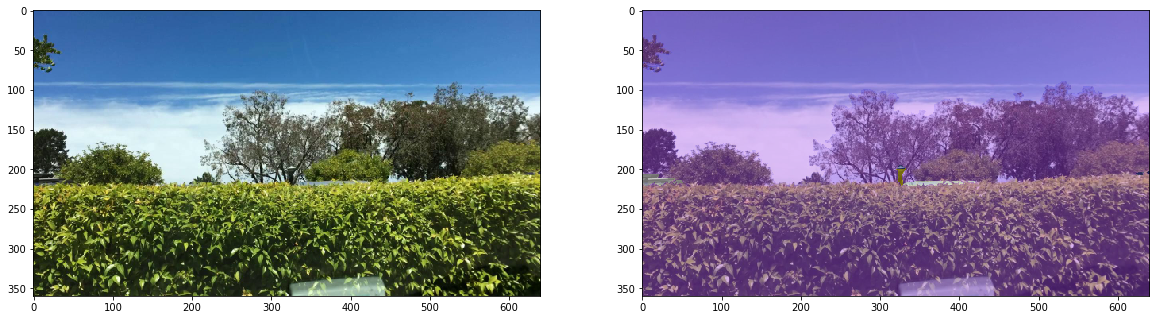

In [14]:
i = 0
image, label = next(train_generator)
image = image[i]
label = np.argmax(label[i], axis=-1)

fig=plt.figure(figsize=(20, 10))

cm = plt.get_cmap('gist_ncar')

fig.add_subplot(1, 2, 1)
plt.imshow(image * .5 + .5)
fig.add_subplot(1, 2, 2)
plt.imshow((image * .5 + .5) * .6 + cm(label/34.)[...,:3] * .4)
plt.show()

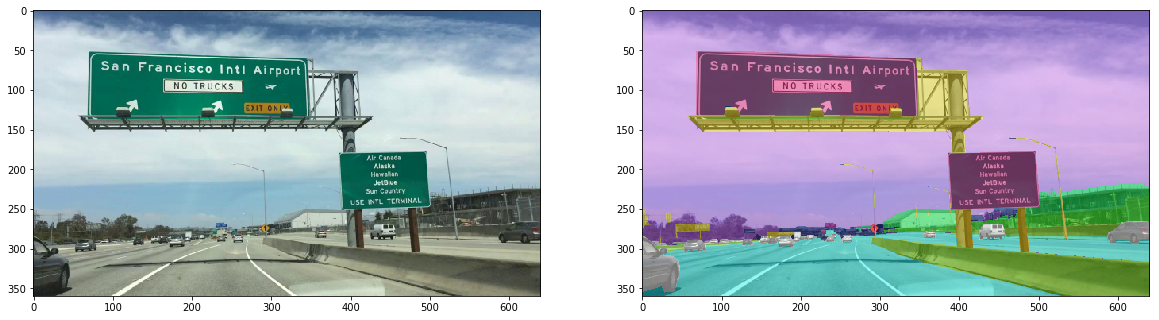

In [15]:
i = 0
image, label = next(train_generator)
image = image[i]
label = np.argmax(label[i], axis=-1)

fig=plt.figure(figsize=(20, 10))

cm = plt.get_cmap('gist_ncar')

fig.add_subplot(1, 2, 1)
plt.imshow(image * .5 + .5)
fig.add_subplot(1, 2, 2)
plt.imshow((image * .5 + .5) * .6 + cm(label/34.)[...,:3] * .4)
plt.show()

In [16]:
import keras.models as models
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K

In [17]:
def create_encoding_layers(input_layer):
    kernel = 3
    filter_size = 64
    pool_size = 2
    
    x = Conv2D(filter_size, kernel, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(pool_size, pool_size))(x)

    x = Conv2D(128, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(pool_size, pool_size))(x)

    x = Conv2D(256, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(pool_size, pool_size))(x)

    x = Conv2D(512, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [18]:
def create_decoding_layers(input_layer):
    kernel = 3
    filter_size = 64
    pool_size = 2

    x = Conv2D(512, kernel, padding='same')(input_layer)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(pool_size,pool_size))(x)
    x = Conv2D(256, kernel, padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(pool_size,pool_size))(x)
    x = Conv2D(128, kernel, padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(pool_size,pool_size))(x)
    x = Conv2D(filter_size, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    
    return x

In [19]:
input_layer = Input((*data_shape, 3))

In [20]:
encoded_layer = create_encoding_layers(input_layer)
decoded_layer = create_decoding_layers(encoded_layer)

In [21]:
final_layer = Conv2D(classes, 1, padding='same')(decoded_layer)
final_layer = Activation('softmax')(final_layer)

In [22]:
semseg_model = Model(inputs=input_layer, outputs=final_layer)

In [23]:
semseg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [24]:
semseg_model.fit_generator(generator=train_generator,
                          steps_per_epoch=len(data_train) // batch_size,
                           epochs=1, validation_data=val_generator,
                           validation_steps=len(data_valid) // batch_size)

Epoch 1/1


ResourceExhaustedError: OOM when allocating tensor with shape[4,360,640,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node up_sampling2d_3/ResizeNearestNeighbor}} = ResizeNearestNeighbor[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/batch_normalization_7/cond/Merge_grad/cond_grad"], align_corners=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](batch_normalization_7/cond/Merge-1-0-TransposeNCHWToNHWC-LayoutOptimizer, up_sampling2d_3/mul)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss/mul/_435}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_3348_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
semseg_model.save_weights('trained_model.h5')